In [1]:
import os
import gc
import sys
import time
import numpy as np
import pandas as pd
import cv2
import PIL.Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from apex import amp
import torchvision
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from warmup_scheduler import GradualWarmupScheduler
from efficientnet_pytorch import model as enet
import albumentations
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
from tqdm.notebook import tqdm
DEVICE = torch.device('cuda')
for i in range(torch.cuda.device_count()):
    print(i, torch.cuda.get_device_name(i))
    print('  allocated:', round(torch.cuda.memory_allocated(i) / 1024 ** 3, 1), 'GB')
    print('  cached:   ', round(torch.cuda.memory_cached(i) / 1024 ** 3, 1), 'GB')

0 Graphics Device
  allocated: 0.0 GB
  cached:    0.0 GB
1 Graphics Device
  allocated: 0.0 GB
  cached:    0.0 GB


In [2]:
MAIN_PATH = '.'
DATA_PATH = '{}/data'.format(MAIN_PATH)
LABELS_PATH = '{}/train.csv'.format(DATA_PATH)
DEBUG = False
APEX = True
M_PARAMS = {
    'MODEL_VER': 'v3',
    'TILES_DIR': '{}/train_images_tiles_q1_256_36/'.format(DATA_PATH),
    'ENET_TYPE': 'efficientnet-b0',
    'N_FOLDS': 4,
    'TILE_SIZE': 256,
    'IMAGE_SIZE': 256,
    'N_TILES': 36,
    'BATCH_SIZE': 6,
    'N_WORKERS': 8,
    'OUT_DIM': 5,
    'LR': 3e-4,
    'N_EPOCHS': 5 if DEBUG else 30
}
print(M_PARAMS)
MODELS_PATH = '{}/effnet_models_{}'.format(MAIN_PATH, M_PARAMS['MODEL_VER'])
if not os.path.exists(MODELS_PATH):
    os.mkdir(MODELS_PATH)
    print('created:', MODELS_PATH)
PRETRAINED_MODEL = {
    'efficientnet-b0': './bbs/efficientnet-b0-355c32eb.pth',
    'efficientnet-b1': './bbs/efficientnet-b1-f1951068.pth',
    'efficientnet-b2': './bbs/efficientnet-b2-8bb594d6.pth',
}
# v0: q1_256_36 folds 4 n_tiles 25 bs 6 no fmap effnet_b1 --> .86 LB

{'MODEL_VER': 'v3', 'TILES_DIR': './data/train_images_tiles_q1_256_36/', 'ENET_TYPE': 'efficientnet-b0', 'N_FOLDS': 4, 'TILE_SIZE': 256, 'IMAGE_SIZE': 256, 'N_TILES': 36, 'BATCH_SIZE': 6, 'N_WORKERS': 8, 'OUT_DIM': 5, 'LR': 0.0003, 'N_EPOCHS': 30}


In [3]:
if DEBUG:
    df_train = pd.read_csv(os.path.join(DATA_PATH, 'train_dsph.csv')).sample(100).reset_index(drop=True)
else:
    df_train = pd.read_csv(os.path.join(DATA_PATH, 'train_dsph.csv'))
df_train.head()

,Unnamed: 0,image_id,data_provider,isup_grade,gleason_score
0,0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


In [4]:
skf = StratifiedKFold(M_PARAMS['N_FOLDS'], shuffle=True, random_state=80)
df_train['fold'] = -1
for i, (train_idx, valid_idx) in enumerate(skf.split(df_train, df_train['isup_grade'])):
    df_train.loc[valid_idx, 'fold'] = i
df_train.head()

,Unnamed: 0,image_id,data_provider,isup_grade,gleason_score,fold
0,0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,1
1,1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,2
2,2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,0
3,3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,3
4,4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,2


In [5]:
class EffNet(nn.Module):
    def __init__(self, backbone, out_dim):
        super(EffNet, self).__init__()
        self.enet = enet.EfficientNet.from_name(backbone)
        self.enet.load_state_dict(torch.load(PRETRAINED_MODEL[backbone]))
        #self.enet = enet.EfficientNet.from_pretrained(backbone)
        nc = self.enet._fc.in_features
        self.myfc = nn.Linear(nc, out_dim)
        self.enet._fc = nn.Identity()
        self.enet = nn.DataParallel(self.enet)
    def forward(self, x):
        x = self.enet(x)
        x = self.myfc(x)
        return x
class EffNet_(nn.Module):
    def __init__(self, backbone, out_dim):
        super(EffNet_, self).__init__()
        self.enet = enet.EfficientNet.from_name(backbone)
        self.enet.load_state_dict(torch.load(PRETRAINED_MODEL[backbone]))
        nc = self.enet._fc.in_features
        self.enet._fc = nn.Identity()
        self.enet = nn.DataParallel(self.enet)
        self.myfc = nn.DataParallel(nn.Sequential(
            nn.Linear(nc, int(nc / 4)),
            nn.ReLU(),
            #nn.BatchNorm1d(int(nc / 2)), 
            nn.Dropout(.2),
            nn.Linear(int(nc / 4), out_dim)
        ))
    def extract(self, x):
        return self.enet(x)
    def forward(self, x):
        x = self.extract(x)
        x = self.myfc(x)
        return x
class ResNext(nn.Module):
    def __init__(self, out_dim):
        super(ResNext, self).__init__()
        self.rsnxt = torchvision.models.resnext50_32x4d(pretrained=True)
        nc = self.rsnxt.fc.in_features
        self.rsnxt.fc = nn.Sequential(
            Flatten(),
            nn.Linear(nc, int(nc / 2)),
            nn.ReLU(),
            nn.BatchNorm1d(int(nc / 2)), 
            nn.Dropout(.4),
            nn.Linear(int(nc / 2), out_dim)
        )
        self.rsnxt = nn.DataParallel(self.rsnxt)
    def forward(self, x):
        x = self.rsnxt(x)
        return x

In [6]:
model = EffNet_(M_PARAMS['ENET_TYPE'], M_PARAMS['OUT_DIM'])
model.children

<bound method Module.children of EffNet_(
  (enet): DataParallel(
    (module): EfficientNet(
      (_conv_stem): Conv2dStaticSamePadding(
        3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
        (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
      )
      (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_blocks): ModuleList(
        (0): MBConvBlock(
          (_depthwise_conv): Conv2dStaticSamePadding(
            32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
            (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
          )
          (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (_se_reduce): Conv2dStaticSamePadding(
            32, 8, kernel_size=(1, 1), stride=(1, 1)
            (static_padding): Identity()
          )
          (_se_expand): Conv2dStaticSamePadding(
            8, 32, ker

In [7]:
def get_tiles(img_id, n_tiles):
        result = []
        seq_imgs = []
        for i in range(n_tiles):
            img_path = '{}/{}_{}.png'.format(M_PARAMS['TILES_DIR'], img_id, i)
            img = cv2.imread(img_path)
            if not np.any(img):
                print('no img file read:', img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            seq_imgs.append(img)
        for i in range(len(seq_imgs)):
            result.append({'img':seq_imgs[i], 'idx':i})
        return result
class PANDADataset(Dataset):
    def __init__(self, df, image_size, n_tiles, tile_mode=0, rand=False,
                 transform=None, transform_tile=None):
        self.df = df.reset_index(drop=True)
        self.image_size = image_size
        self.n_tiles = n_tiles
        self.tile_mode = tile_mode
        self.rand = rand
        self.transform = transform
        self.transform_tile = transform_tile
    def __len__(self):
        return self.df.shape[0]
    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_id = row.image_id
        tiles = get_tiles(img_id, self.n_tiles)
        if self.rand:
            idxes = np.random.choice(list(range(self.n_tiles)), self.n_tiles, replace=False)
        else:
            idxes = list(range(self.n_tiles))
        n_row_tiles = int(np.sqrt(self.n_tiles))
        images = np.zeros((self.image_size * n_row_tiles, self.image_size * n_row_tiles, 3))
        for h in range(n_row_tiles):
            for w in range(n_row_tiles):
                i = h * n_row_tiles + w
                if len(tiles) > idxes[i]:
                    this_img = tiles[idxes[i]]['img']
                else:
                    this_img = np.ones((self.image_size, self.image_size, 3)).astype(np.uint8) * 255
                this_img = (255 - this_img) / 255
                if self.transform_tile is not None:
                    this_img = self.transform_tile(image=this_img)['image']
                h1 = h * self.image_size
                w1 = w * self.image_size
                images[h1:h1+self.image_size, w1:w1+self.image_size] = this_img
        images = images.astype(np.float32)
        if self.transform is not None:
            images = self.transform(image=images)['image']
        #images /= 255
        images = images.transpose(2, 0, 1)
        label = np.zeros(5).astype(np.float32)
        label[:row.isup_grade] = 1.
        return torch.tensor(images), torch.tensor(label)

In [8]:
transforms_train = albumentations.Compose(
    [
        albumentations.OneOf(
            [
                albumentations.RandomBrightness(limit=.15), 
                albumentations.RandomContrast(limit=.3), 
                albumentations.RandomGamma()
            ], 
            p=.33
        ),
        albumentations.Transpose(p=.5),
        albumentations.VerticalFlip(p=.5),
        albumentations.HorizontalFlip(p=.5),
        albumentations.ShiftScaleRotate(shift_limit=.1, scale_limit=.1, rotate_limit=15, p=.33)
    ]
)
transforms_train_tile = albumentations.Compose(
    [
        albumentations.Transpose(p=.5),
        albumentations.VerticalFlip(p=.5),
        albumentations.HorizontalFlip(p=.5)
    ]
)

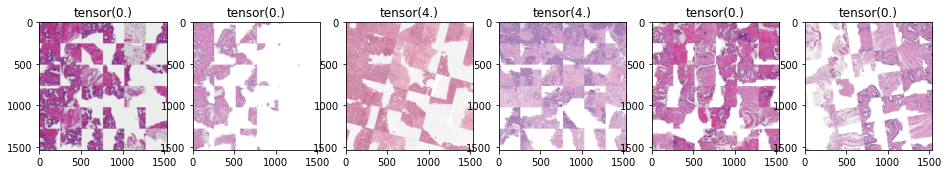

In [9]:
dataset_show = PANDADataset(
    df_train,
    M_PARAMS['IMAGE_SIZE'], 
    M_PARAMS['N_TILES'], 
    0, 
    transform=transforms_train,
    transform_tile=transforms_train_tile
)
from pylab import rcParams
rcParams['figure.figsize'] = (16, 4)
f, axarr = plt.subplots(1, M_PARAMS['BATCH_SIZE'])
for i in range(M_PARAMS['BATCH_SIZE']):
    img, label = dataset_show.__getitem__(i)
    axarr[i].imshow(1. - img.transpose(0, 1).transpose(1,2).squeeze())
    axarr[i].set_title(str(sum(label)))

In [10]:
criterion = nn.BCEWithLogitsLoss()
def train_epoch(loader, optimizer):
    model.train()
    train_loss = []
    bar = tqdm(loader)
    for (data, target) in bar:
        data, target = data.to(DEVICE), target.to(DEVICE)
        loss_func = criterion
        optimizer.zero_grad()
        logits = model(data)
        loss = loss_func(logits, target)
        with amp.scale_loss(loss, optimizer) as scaled_loss:
            scaled_loss.backward()
        #loss.backward()
        optimizer.step()
        loss_np = loss.detach().cpu().numpy()
        train_loss.append(loss_np)
        smooth_loss = sum(train_loss[-100:]) / min(len(train_loss), 100)
        bar.set_description('loss: %.5f, smth: %.5f' % (loss_np, smooth_loss))
    return train_loss
def val_epoch(loader, get_output=False):
    model.eval()
    val_loss = []
    LOGITS = []
    PREDS = []
    TARGETS = []
    with torch.no_grad():
        for (data, target) in tqdm(loader):
            data, target = data.to(DEVICE), target.to(DEVICE)
            logits = model(data)
            loss = criterion(logits, target)
            pred = logits.sigmoid().sum(1).detach().round()
            LOGITS.append(logits)
            PREDS.append(pred)
            TARGETS.append(target.sum(1))
            val_loss.append(loss.detach().cpu().numpy())
        val_loss = np.mean(val_loss)
    LOGITS = torch.cat(LOGITS).cpu().numpy()
    PREDS = torch.cat(PREDS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()
    acc = (PREDS == TARGETS).mean() * 100.
    qwk = cohen_kappa_score(PREDS, TARGETS, weights='quadratic')
    qwk_k = cohen_kappa_score(
        PREDS[df_valid['data_provider'] == 'karolinska'], 
        df_valid[df_valid['data_provider'] == 'karolinska'].isup_grade.values, 
        weights='quadratic'
    )
    qwk_r = cohen_kappa_score(
        PREDS[df_valid['data_provider'] == 'radboud'], 
        df_valid[df_valid['data_provider'] == 'radboud'].isup_grade.values, 
        weights='quadratic'
    )
    print('qwk', qwk, 'qwk_k', qwk_k, 'qwk_r', qwk_r)
    if get_output:
        return LOGITS
    else:
        return val_loss, acc, qwk

In [ ]:
pred, target = [], []
if DEBUG:
    n_folds_train = 2
else:
    n_folds_train = M_PARAMS['N_FOLDS']
start_folds_train = 0
for fold_num in range(start_folds_train, n_folds_train):
    print('-' * 20, 'fold:', fold_num, '-' * 20)
    train_idx = np.where((df_train['fold'] != fold_num))[0]
    valid_idx = np.where((df_train['fold'] == fold_num))[0]
    df_this  = df_train.loc[train_idx]
    df_valid = df_train.loc[valid_idx]
    dataset_train = PANDADataset(
        df_this, 
        M_PARAMS['IMAGE_SIZE'], 
        M_PARAMS['N_TILES'], 
        transform=transforms_train,
        transform_tile=transforms_train_tile
    )
    dataset_valid = PANDADataset(
        df_valid, 
        M_PARAMS['IMAGE_SIZE'], 
        M_PARAMS['N_TILES']
    )
    train_loader = torch.utils.data.DataLoader(
        dataset_train, 
        batch_size=M_PARAMS['BATCH_SIZE'], 
        sampler=RandomSampler(dataset_train), 
        num_workers=M_PARAMS['N_WORKERS']
    )
    valid_loader = torch.utils.data.DataLoader(
        dataset_valid, 
        batch_size=M_PARAMS['BATCH_SIZE'], 
        sampler=SequentialSampler(dataset_valid), 
        num_workers=M_PARAMS['N_WORKERS']
    )
    model = EffNet(M_PARAMS['ENET_TYPE'], out_dim=M_PARAMS['OUT_DIM']) 
    #model = ResNext(out_dim=OUT_DIM)
    model = model.to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=M_PARAMS['LR'])
    model, optimizer = amp.initialize(model, optimizer, opt_level='O1')
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=N_EPOCHS)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=M_PARAMS['LR'], 
        total_steps=M_PARAMS['N_EPOCHS'],
        div_factor=30, 
        final_div_factor=10000,
        pct_start=(2 / M_PARAMS['N_EPOCHS'])
    )
    print('train len:', len(dataset_train),'| val len:', len(dataset_valid))
    qwk_max = 0
    best_file = '{}/{}_best_fold{}.pth'.format(MODELS_PATH, M_PARAMS['ENET_TYPE'], fold_num)
    for epoch in tqdm(range(M_PARAMS['N_EPOCHS']), desc='epochs'):
        print(time.ctime(), 'epoch:', epoch)
        train_loss = train_epoch(train_loader, optimizer)
        val_loss, acc, qwk = val_epoch(valid_loader)
        content = '{} epoch {}, lr: {:.7f}, train loss: {:.5f}, val loss: {:.5f}, acc: {:.5f}, QWK: {:.5f}'.format(
                time.ctime(),
                epoch, 
                optimizer.param_groups[0]['lr'], 
                np.mean(train_loss),
                np.mean(val_loss),
                acc,
                qwk
            )
        print(content)
        with open('{}/log_{}_fold{}.txt'.format(MODELS_PATH, M_PARAMS['ENET_TYPE'], fold_num), 'a') as appender:
            appender.write(content + '\n')
        if qwk > qwk_max:
            torch.save(model.state_dict(), best_file)
            print('QWK improved {:.6f} --> {:.6f} model saved'.format(qwk_max, qwk))
            qwk_max = qwk
        scheduler.step(epoch)
    with open('{}/log_{}_folds_all.txt'.format(MODELS_PATH, M_PARAMS['ENET_TYPE']), 'a') as appender:
        appender.write('{} | fold: {} | max QWK: {:.6f}\n'.format(M_PARAMS, fold_num, qwk_max))
    torch.save(
        model.state_dict(), 
        os.path.join('{}/{}_final_fold{}.pth'.format(MODELS_PATH, M_PARAMS['ENET_TYPE'], fold_num))
    )
    del model, dataset_train, dataset_valid, train_loader, valid_loader
    torch.cuda.empty_cache()
    gc.collect()

-------------------- fold: 0 --------------------
Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
train len: 7887 | val len: 2629


Sun Jul  5 17:55:22 2020 epoch: 0


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0




qwk 0.5833398325784909 qwk_k 0.5102224993805113 qwk_r 0.4987692735804905
Sun Jul  5 18:16:50 2020 epoch 0, lr: 0.0000100, train loss: 0.52802, val loss: 0.39919, acc: 28.03347, QWK: 0.58334
QWK improved 0.000000 --> 0.583340 model saved
Sun Jul  5 18:16:50 2020 epoch: 1



qwk 0.6804453685470269 qwk_k 0.6394212522859971 qwk_r 0.6093599771624322
Sun Jul  5 18:37:56 2020 epoch 1, lr: 0.0000100, train loss: 0.44021, val loss: 0.35296, acc: 35.52682, QWK: 0.68045
QWK improved 0.583340 --> 0.680445 model saved
Sun Jul  5 18:37:56 2020 epoch: 2


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0




qwk 0.7974531758437444 qwk_k 0.8097260292689148 qwk_r 0.7236504038497025
Sun Jul  5 18:55:34 2020 epoch 2, lr: 0.0003000, train loss: 0.38296, val loss: 0.29791, acc: 44.35146, QWK: 0.79745
QWK improved 0.680445 --> 0.797453 model saved
Sun Jul  5 18:55:34 2020 epoch: 3



qwk 0.7719595992657933 qwk_k 0.7562658013475752 qwk_r 0.7298916702032693
Sun Jul  5 19:13:13 2020 epoch 3, lr: 0.0002991, train loss: 0.31566, val loss: 0.30390, acc: 55.99087, QWK: 0.77196
Sun Jul  5 19:13:13 2020 epoch: 4


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0




qwk 0.8117653327364078 qwk_k 0.7837129757336018 qwk_r 0.7805138820755819
Sun Jul  5 19:30:52 2020 epoch 4, lr: 0.0002962, train loss: 0.28298, val loss: 0.26528, acc: 60.44123, QWK: 0.81177
QWK improved 0.797453 --> 0.811765 model saved
Sun Jul  5 19:30:52 2020 epoch: 5



qwk 0.8416321929810006 qwk_k 0.8550935656823793 qwk_r 0.7911340055263785
Sun Jul  5 19:48:30 2020 epoch 5, lr: 0.0002916, train loss: 0.26717, val loss: 0.23848, acc: 57.28414, QWK: 0.84163
QWK improved 0.811765 --> 0.841632 model saved
Sun Jul  5 19:48:30 2020 epoch: 6


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0




qwk 0.8410196372386558 qwk_k 0.8693168247755093 qwk_r 0.780235819946515
Sun Jul  5 20:06:08 2020 epoch 6, lr: 0.0002851, train loss: 0.25931, val loss: 0.23813, acc: 59.60441, QWK: 0.84102
Sun Jul  5 20:06:08 2020 epoch: 7


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0




qwk 0.8292656503389255 qwk_k 0.8428259204170283 qwk_r 0.7778072170811147
Sun Jul  5 20:23:47 2020 epoch 7, lr: 0.0002770, train loss: 0.24731, val loss: 0.24794, acc: 55.64854, QWK: 0.82927
Sun Jul  5 20:23:47 2020 epoch: 8



qwk 0.8482963197903948 qwk_k 0.8556163847952465 qwk_r 0.8079263032601327
Sun Jul  5 20:41:25 2020 epoch 8, lr: 0.0002673, train loss: 0.23716, val loss: 0.23327, acc: 63.29403, QWK: 0.84830
QWK improved 0.841632 --> 0.848296 model saved
Sun Jul  5 20:41:25 2020 epoch: 9


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0




qwk 0.8647884929370624 qwk_k 0.8766461713588947 qwk_r 0.824104488396222
Sun Jul  5 20:59:03 2020 epoch 9, lr: 0.0002561, train loss: 0.22960, val loss: 0.24007, acc: 59.87067, QWK: 0.86479
QWK improved 0.848296 --> 0.864788 model saved
Sun Jul  5 20:59:03 2020 epoch: 10



qwk 0.8499628149606527 qwk_k 0.8557468623559714 qwk_r 0.8126664127415072
Sun Jul  5 21:16:41 2020 epoch 10, lr: 0.0002435, train loss: 0.22396, val loss: 0.22970, acc: 59.83264, QWK: 0.84996
Sun Jul  5 21:16:41 2020 epoch: 11


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0




qwk 0.8547173411199704 qwk_k 0.8750977070571939 qwk_r 0.8098812598809944
Sun Jul  5 21:34:19 2020 epoch 11, lr: 0.0002298, train loss: 0.21677, val loss: 0.22275, acc: 63.67440, QWK: 0.85472
Sun Jul  5 21:34:19 2020 epoch: 12


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0




qwk 0.8689491401362214 qwk_k 0.8852400067075019 qwk_r 0.824691754754126
Sun Jul  5 21:51:59 2020 epoch 12, lr: 0.0002151, train loss: 0.21051, val loss: 0.22245, acc: 64.66337, QWK: 0.86895
QWK improved 0.864788 --> 0.868949 model saved
Sun Jul  5 21:51:59 2020 epoch: 13



qwk 0.8728476475199598 qwk_k 0.8903608589064833 qwk_r 0.8265279243635233
Sun Jul  5 23:02:31 2020 epoch 16, lr: 0.0001500, train loss: 0.18280, val loss: 0.21585, acc: 63.21795, QWK: 0.87285
QWK improved 0.868949 --> 0.872848 model saved
Sun Jul  5 23:02:31 2020 epoch: 17


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0

